In [1]:
from math import sqrt
import networkx as nx, numpy as np

In [2]:
#Makes a contact graph using the Barabasi-Albert algorithm to simulate social networks

#Inputs are nodes and edges (the number of nodes and edges)
# and cont_rate, which weights the fraction of time two nodes spend in contact

#Output:
#A graph where the none of the nodes are infected tested
#The edges simulate that the nodes came together a time t_start and stayed together for time t_tog

def make_cont_ba(nodes, cont_rate, edges=None):
    if not edges: #If you don't specify the number of edges for each node,
        #Choose the larger of 2 or the square root of the number of nodes
        edges=max(2,int(sqrt(nodes)/2))
    my_graph=nx.generators.random_graphs.barabasi_albert_graph(nodes, edges)
    time_start={e:np.random.rand() for e in my_graph.edges} #Random values for t_start
    nx.set_edge_attributes(my_graph, time_start, 't_start')
    time_tog={e:np.random.rand()*cont_rate for e in my_graph.edges} #Random values for t_tog weighted by cont_rate
    nx.set_edge_attributes(my_graph, time_tog, 't_tog')
    nx.set_node_attributes(my_graph, 0, 'tested')
    nx.set_node_attributes(my_graph, 0, 'infected')
    nx.set_node_attributes(my_graph, -1, 'source')
    nx.set_node_attributes(my_graph, -1, 'inf_time')
    return my_graph

In [3]:
#Simulates one node being infected where infection rate is inf_rate (if they spent time 1 together)
#Inputs a graph where that node was just infected by source (node) at inf_time
#Outputs a graph that simulates that node's infection other nodes
def sim_node_inf(graph, node, source, inf_time, inf_rate):
    new_graph=graph
    #Node received infection from source at inf_time
    new_graph.nodes[node]['infected']=1 
    new_graph.nodes[node]['source']=source
    new_graph.nodes[node]['inf_time']=inf_time 
    
    #The infection can spread to other nodes it interacted with after the infection time
    poss_spread=[n for n in new_graph.neighbors(node) if new_graph.edges[(node,n)]['t_start']>inf_time]
    print('Node {} infected by {} at time {}. Possible new infections:'.format(node, source, inf_time),
          ', '.join([str(n) for n in poss_spread]))
    
    for spread_node in poss_spread: #For each of these nodes
        inf_chance=1-math.exp(-new_graph.edges[(node,spread_node)]['t_tog']/inf_rate) #Calculate the infection chance
        #The new infection is assumed to be the end of the source and infected nodes' time together
        new_inf_time=new_graph.edges[(node,spread_node)]['t_start']+new_graph.edges[(node,spread_node)]['t_tog']
        
        #If there is an infection (and the spread node isn't already infected
        if np.random.rand()<inf_chance and not new_graph.nodes[spread_node]['infected']:
            #Generate a new graph with that node as an infection source
            new_graph=sim_node_inf(new_graph, spread_node, node, new_inf_time, inf_rate)
            
    return new_graph

#Simulates infection of every node in a graph
#Inputs are a contact graph (such as from make_cont_ba), num_seed and num_tested as number
# of nodes seeded and tested, and inf_rate (infection rate if they spent time 1 together)
#Outputs is a graph with simulation for infections and tests
def sim_graph_inf(graph, num_seed, num_tested, inf_rate):
    new_graph=graph
    
    #Choose num_seed nodes to be the sources of infection
    seeds=np.random.choice(new_graph.nodes,num_seed, replace=False)
    for seed_node in seeds:
        new_graph.nodes[seed_node]['infected']=1
    
    #then simulate the resulting infections
    for source_node in seeds:
        new_graph=sim_node_inf(new_graph, source_node, -1, 0, inf_rate)
        
    #then choose num_tested to be tested
    for t_node in np.random.choice(graph.nodes,num_tested, replace=False):
        new_graph.nodes[t_node]['tested']=1
    return new_graph

Node 2 infected by -1 at time 0. Possible new infections: 0, 1, 3, 4
Node 0 infected by 2 at time 0.21021307688402363. Possible new infections: 4
Node 4 infected by 2 at time 0.8563092854186736. Possible new infections: 0
Infected: [1, 0, 1, 0, 1, 0, 0, 0]
Tested:   [0, 0, 1, 0, 1, 0, 0, 0]


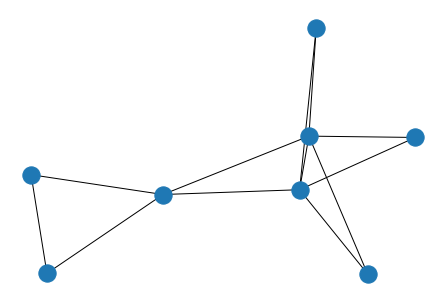

In [7]:
%matplotlib inline

#An example of an infection graph
test_graph=make_cont_ba(8, 0.1, edges=2)
inf_graph=sim_graph_inf(test_graph, 1, 2, 10)
print('Infected:', [inf_graph.nodes[node]['infected'] for node in inf_graph.nodes])
print('Tested:  ', [inf_graph.nodes[node]['tested'] for node in inf_graph.nodes])
nx.draw(inf_graph)

Node 1 infected by -1 at time 0. Possible new infections: 3, 4, 11, 13
Node 13 infected by 1 at time 0.35172734957385393. Possible new infections: 3
Node 0 infected by -1 at time 0. Possible new infections: 3, 4, 5, 6, 10, 12
Node 6 infected by 0 at time 0.6733581801409231. Possible new infections: 3
Node 12 infected by 0 at time 0.6053144993748305. Possible new infections: 14
Node 14 infected by -1 at time 0. Possible new infections: 9, 11, 12
Node 11 infected by 14 at time 0.3069312197630507. Possible new infections: 4
[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]


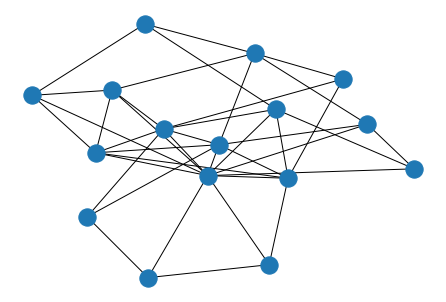

In [8]:
#A more complicatied example of an infection graph
test_graph2=make_cont_ba(16, 0.1, edges=3)
inf_graph2=sim_graph_inf(test_graph2, 3, 5, 5)
print([inf_graph2.nodes[node]['infected'] for node in inf_graph2.nodes])
print([inf_graph2.nodes[node]['tested'] for node in inf_graph2.nodes])
nx.draw(inf_graph2)

In [9]:
[(e[0],e[1],inf_graph2.edges[e]['t_start'], inf_graph2.edges[e]['t_tog']) for e in inf_graph2.edges]

[(0, 3, 0.7683062782741023, 0.023734619807965596),
 (0, 4, 0.7267005530134754, 0.09408486258876458),
 (0, 5, 0.4147364526114924, 0.07021376852985572),
 (0, 6, 0.6041407399781039, 0.06921744016281918),
 (0, 10, 0.8992914623660079, 0.09773320568255889),
 (0, 12, 0.5636623314903468, 0.041652167884483705),
 (1, 3, 0.19854875597743626, 0.045064455145422434),
 (1, 4, 0.32547843746222127, 0.05384468996908746),
 (1, 11, 0.2533372570206024, 0.025658362308310936),
 (1, 13, 0.26913516316748054, 0.08259218640637339),
 (2, 3, 0.05046938298092474, 0.08252420600105465),
 (2, 7, 0.6142988751490497, 0.08759728572046109),
 (2, 8, 0.8795121780838515, 0.026877440322800584),
 (3, 4, 0.09634464389051767, 0.08219190865903848),
 (3, 5, 0.01366920725578824, 0.029074084579345894),
 (3, 6, 0.8212591546902853, 0.09813764630186372),
 (3, 8, 0.6210851476148268, 0.0295663140884765),
 (3, 9, 0.1825591683814919, 0.05981402419051002),
 (3, 10, 0.5221673244610959, 0.004952091787638214),
 (3, 12, 0.48495873241518817, 0.0